In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')

import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [13]:
print(u_test[4])

[2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188
 2.44694188 2.44694188 2.44694188 2.44694188 2.44694188 2.4469

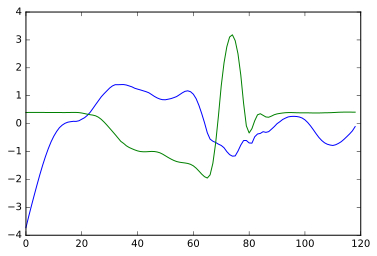

In [8]:
plot(y_train[0][:,:2]) # sample every 5 frames

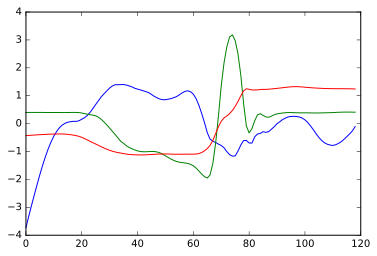

In [10]:
plot(y_train[0][:,:3]) # sample every 6 frames

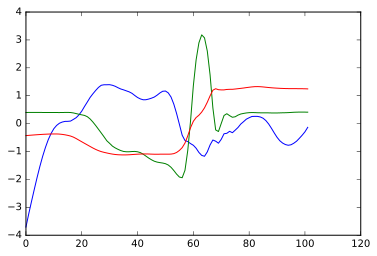

In [15]:
plot(y_train[0][:,:3]) # sample every 7 frames 

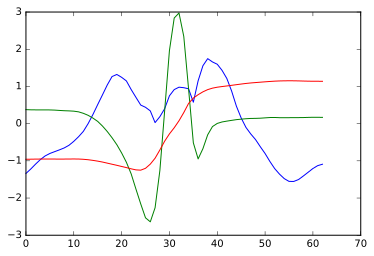

In [18]:
plot(y_train[2][:,:3]) # sample every 8 frames

# No control

- golf seem to have good training low loss with 3 dimisional hidden layer

In [ ]:
## --- Training --- ##
## Initialize model
YD = np.shape(y_train[0])[1]
HD = 1
win_out = 20
m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=70,
        kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                 RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
        nSamples=5, q_hidden_units=[100,100], h0_hidden_units=[100,100], ctx=ctx, dtype=np.float64)
    
## Initialize parameters
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD,))*3,np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(((win_out+1)*HD+win_out*YD,)),np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([1e-4]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([np.var(np.vstack(y_train))*0.001]),np.float64))    
  
## Train model
m.optimize(Y=y_train, max_iters=300, step_rate=0.03)
m.optimize(Y=y_train, max_iters=500, step_rate=0.02)
m.optimize(Y=y_train, max_iters=1500, step_rate=0.01)
m.optimize(Y=y_train, max_iters=1500, step_rate=0.005)
# m.optimize(Y=y_train, max_iters=1500, step_rate=0.005)
    
## Save model
m.save_params('./models/no_control_jump1') 

In [ ]:
m.optimize(Y=y_train, max_iters=1000, step_rate=0.01)
m.optimize(Y=y_train, max_iters=1000, step_rate=0.005)

In [11]:
## Save model
m.save_params('./models/no_control_jump1')

In [20]:
def test_run(model, seq, win_out,  test_data, HD, win_in=None,control_signal=None, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
        
        
        m = RGP(wins=[win_out, win_out], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=100,
                kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                         U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    else:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        
    
        m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=100,
                kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True,dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200, 200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [26]:
## --- testing --- ##
win_out = 20
HD=1

num_test_seq = np.shape(y_test_list)[1]
y_pds = [[] for _ in range(num_test_seq)]
u_test_list = []
for seq in range(num_test_seq):
    y_pds[seq] = test_run('no_control_jump1', seq, win_out, y_test, HD, MEAN_PRED=True, with_control=False) # output array
    
    
pds = [[] for _ in range(num_test_seq)]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, y_test_mean[seq], y_test_std[seq])
    
### Write .amc motion files
for seq, pd in enumerate(pds):
    filename = './predictions/no_control_jump1_seq'+str(seq)
    helper.write_amc(pd, filename)
    break

Observationa dimension: 62
Observationa dimension: 62
Observationa dimension: 62
Observationa dimension: 62
Observationa dimension: 62


In [ ]:
## HD=1, SAMPLE every 6 frames, smaller length scale initiation
print(helper.compute_MSE(y_test_list,y_pds))

In [27]:
## HD=1, sample every 6 frames
print(helper.compute_MSE(y_test_list, y_pds))

[0.636260272068051, 0.9981325588939188, 1.14144123843514, 0.9992387530996708, 1.0828886568485006]


In [14]:
## HD=1
print(helper.compute_MSE(y_test_list, y_pds))

[0.6861592574410055, 0.7505702189427264, 0.6679271548934466, 0.6773747591355601, 0.7497360100767205]


In [8]:
## HD=2
print(helper.compute_MSE(y_test_list, y_pds))

[0.7708604341107804, 0.7996055238409004, 0.8735667653728767, 0.9134716471088832, 1.201044427502839]


In [7]:
## HD=3
print(helper.compute_MSE(y_test_list,y_pds))

[0.9917662688891212, 0.9867210641030856, 0.9551932460690521, 0.7800746625176953, 1.1614388857438704]


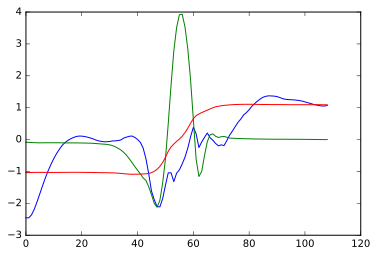

In [9]:
plot(y_test[0][:,:3])

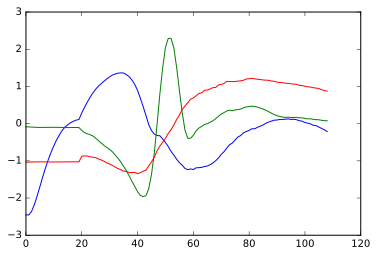

In [23]:
plot(y_pds[0][:,:3])

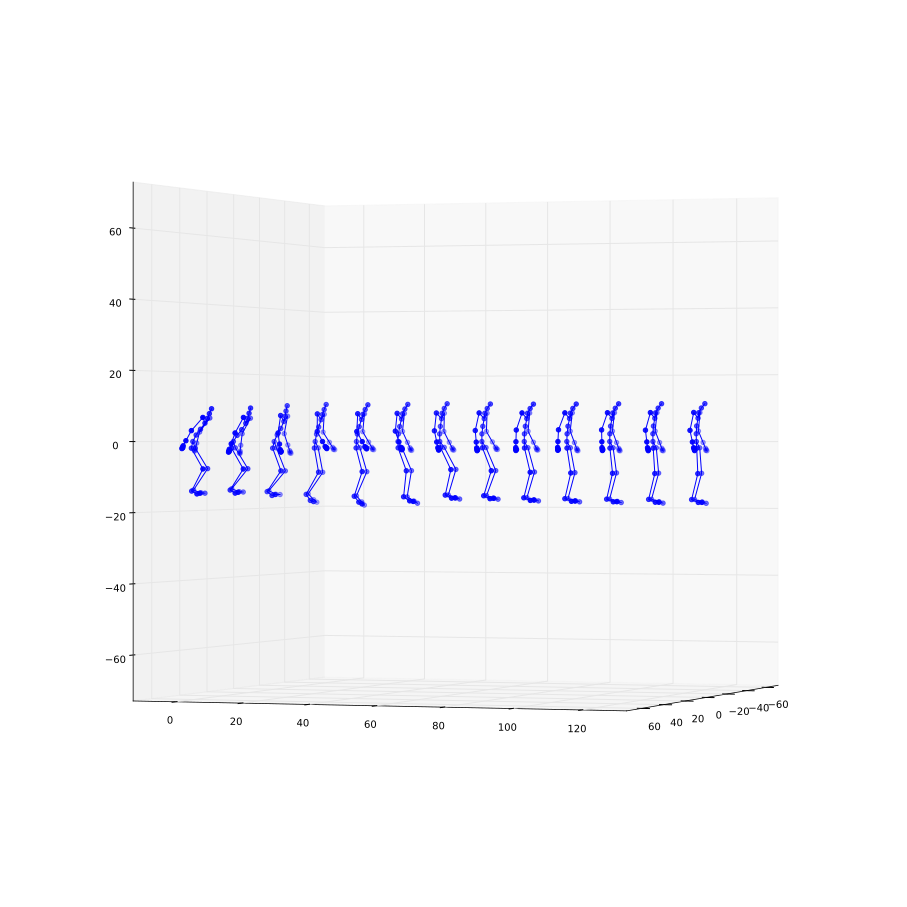

In [24]:
helper.save_trail(y_pds[0][:,3:], y_test_mean[0][3:], y_test_std[0][3:], m_jump['skel'], "no_control_jump1")

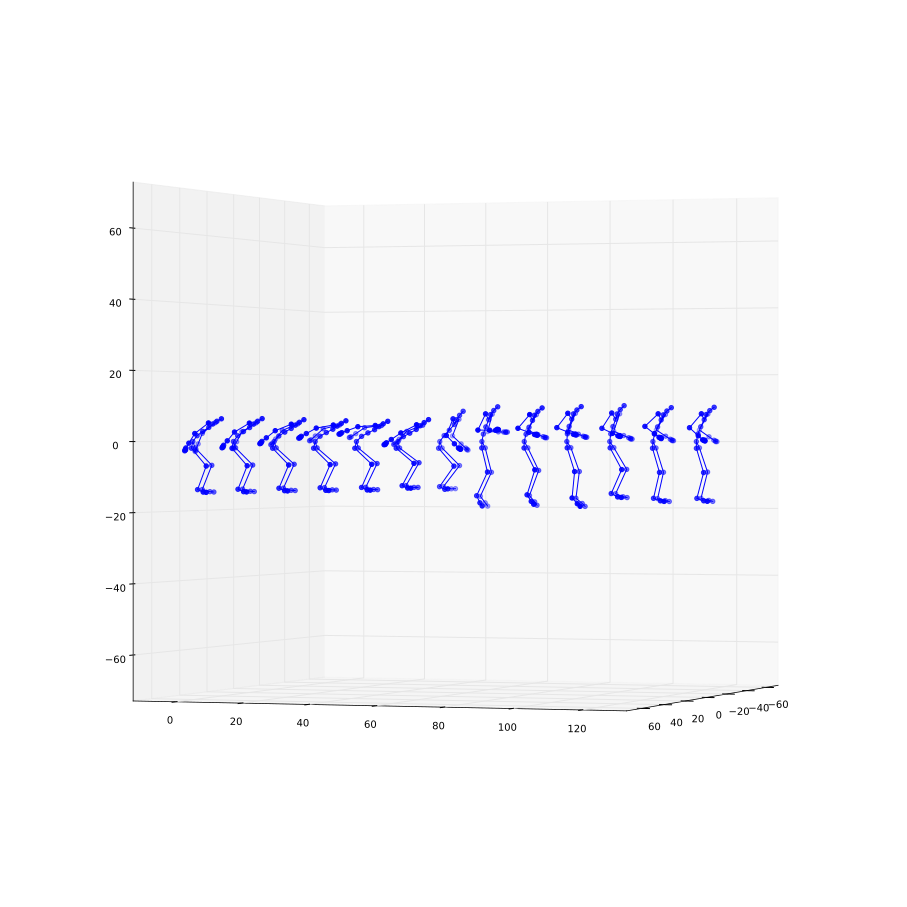

In [15]:
helper.save_trail(y_train[0][:,3:], y_train_mean[0][3:], y_train_std[0][3:], m_jump['skel'], "original_jump")

# Control

In [53]:
train_motions = ['01', '02', '03', '04', '05', 
                 '06', '07', '08', '09', '10',
                 '11', '12', '13', '14', '15'] 
#                  '16', '17', '18', '19', '20'] 
                 #'21', '22', '23', '24', '25']
test_motions = ['26', '27', '28', '29', '30']
subject = '118'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m_jump = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=7, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m_jump['Y'], m_jump['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m_jump['Ytest'], m_jump['lblstest'])

y_train_list, y_train_mean_list, y_train_std_list = [],[],[]
for item in y_train:
    out, mean, std = helper.normalise_data(item)
    y_train_list.append(out)
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
    
    
y_test_list, y_test_mean_list, y_test_std_list = [], [], []
for item in y_test:
    out, mean, std = helper.normalise_data(item)
    y_test_list.append(out)
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)

    
    
## Reshape the sequences
y_train = helper.reshape(y_train_list)
y_train_mean = helper.reshape(y_train_mean_list)
y_train_std = helper.reshape(y_train_std_list)

y_test = helper.reshape(y_test_list)
y_test_mean = helper.reshape(y_test_mean_list)
y_test_std = helper.reshape(y_test_std_list)

u_train = []
for item in y_train:
    var = max(item[:,1])-min(item[:,1])
    u_train.append(np.ones(item.shape[0])[:,None]*var)
    
    
u_test = []
for item in y_test:
    var = max(item[:,1])-min(item[:,1])
    u_test.append(np.ones(item.shape[0])[:,None]*var)
   

In [54]:
## --- Training --- ##
YD = np.shape(y_train[0])[-1]
UD = 1
HD = 1
win_in = 30
win_out = 30

m = RGP(wins=[win_out, win_out], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=80,
        kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                 RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
        nSamples=5, q_hidden_units=[200,300,200], h0_hidden_units=[200,300,200], ctx=ctx, dtype=np.float64)
    
## Initialize parameters
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD+win_in*UD,))*3,np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(((win_out+1)*HD+win_out*YD,))*20,np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([1e-4]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([np.var(np.vstack(y_train))*0.001]),np.float64))    
  
## Train model
m.optimize(Y=y_train, U=u_train, max_iters=300, step_rate=0.03)
m.optimize(Y=y_train, U=u_train, max_iters=300, step_rate=0.02)
m.optimize(Y=y_train, U=u_train, max_iters=1000, step_rate=0.01)
m.save_params('./models/control_jump1')
m.optimize(Y=y_train, U=u_train, max_iters=1000, step_rate=0.005)
    
## Save model
# m.save_params('./models/control_jump1') 

100%|██████████| 1000/1000 [3:55:09<00:00, 14.11s/it, loss=4.67e+04] 


In [55]:
m.save_params('./models/control_jump1')

In [56]:
def test_run(model, seq, win_out,  test_data, HD, win_in=None,control_signal=None, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
        
        m = RGP(wins=[win_out, win_out], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=80,
                kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                         U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    else:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        
    
        m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=80,
                kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True,dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200, 200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [57]:
## --- testing --- ## -

win_in = 30
win_out = 30
HD=1

num_test_seq = np.shape(y_test)[0]
y_pds = [[] for _ in range(num_test_seq)]
u_test_list = []
for seq in range(num_test_seq):
    y_pds[seq] = test_run('control_jump1', seq, win_out, y_test, HD, win_in, u_test, 
                          MEAN_PRED=True, with_control=True) # output array
    
pds = [[] for _ in range(num_test_seq)]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, y_test_mean[seq], y_test_std[seq])
    
### Write .amc motion files
for seq, pd in enumerate(pds):
    filename = './predictions/control(30)_jump1_seq'+str(seq)
    helper.write_amc(pd, filename)
    break

Observationa dimension: 62
Control signal dimension: 1
Observationa dimension: 62
Control signal dimension: 1
Observationa dimension: 62
Control signal dimension: 1
Observationa dimension: 62
Control signal dimension: 1
Observationa dimension: 62
Control signal dimension: 1


In [58]:
## HD=1
print(helper.compute_MSE(y_test_list, y_pds))

[0.8501091716374709, 0.4429132425405266, 0.6391887114082173, 0.5389367013755071, 1.4908040911945433]


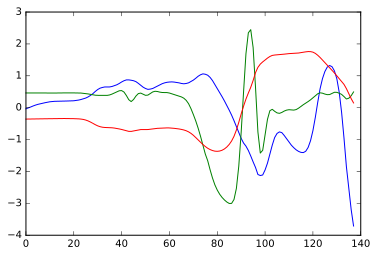

In [47]:
plot(y_test[4][:,:3])

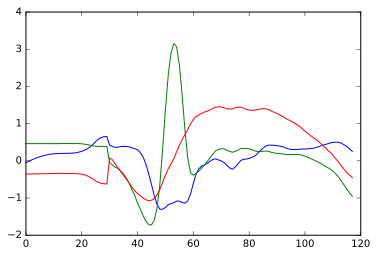

In [59]:
plot(y_pds[4][:,:3])

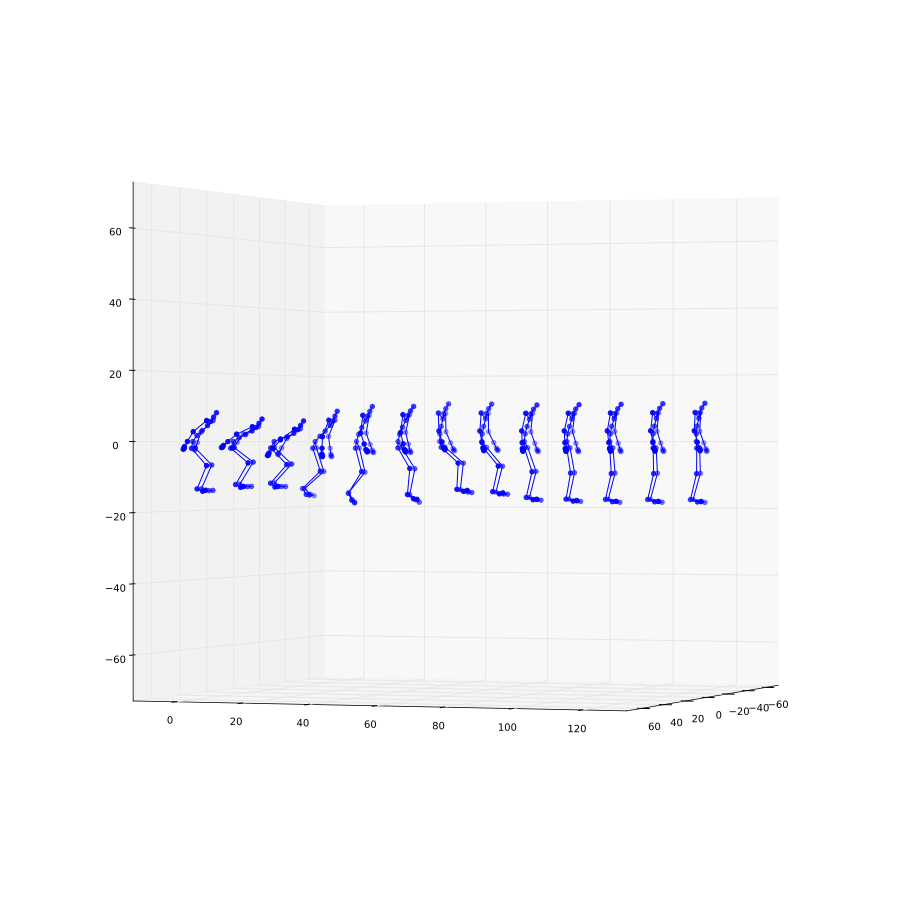

In [64]:
helper.save_trail(y_pds[2][:,3:], y_test_mean[2][3:], y_test_std[2][3:], m_jump['skel'], "control_jump")